# STEP : Rarefaction Analysis

Using QIIME2 to create rarefaction graphs.


## Methods
[qiime alpha_rarefaction](https://docs.qiime2.org/2023.2/plugins/available/diversity/alpha-rarefaction/)
```
Generate interactive alpha rarefaction curves by computing rarefactions
between `min_depth` and `max_depth`. The number of intermediate depths to
compute is controlled by the `steps` parameter, with n `iterations` being
computed at each rarefaction depth. If sample metadata is provided, samples
may be grouped based on distinct values within a metadata column.
```


## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "nb-templates/step-rarefaction-analysis2.ipynb"
PAPERMILL_OUTPUT_PATH = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-all/nb-executed-steps/step-rarefaction-analysis-ana-flavia-all.ipynb"
experiment_name = "ana-flavia-all"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest-all-ana.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata-all-ana.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/rede-micro/models/silva-138-99-nb-classifier.qza"
top_n = 20
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


### Defining names, paths and flags

In [5]:
# Experiments
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
!mkdir -p {experiment_folder}

# Imgs folder
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
!mkdir -p {img_folder}

# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
!mkdir -p {qiime_folder}

In [6]:
# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Output -Rarefaction Artifacts
alpha_rarefaction_path = os.path.join(qiime_folder, 'alpha-rarefaction.qza')
alpha_rarefaction_view_path = os.path.join(qiime_folder, 'alpha-rarefaction.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_rarefaction_path)) or replace_files
need_view = not (os.path.isfile(alpha_rarefaction_view_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

In [8]:
alt_tab_path = os.path.join(base_dir, 'data', 'interim', 'dada2-tabs.qza')
# Verify if table file exists and if it is shared
if not os.path.isfile(dada2_tabs_path) and os.path.isfile(alt_tab_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_tab_path, dada2_tabs_path)

In [9]:
# Load Table artifact
tabs = Artifact.load(dada2_tabs_path)
# Filter samples using Metadata IDs
tabs = filter_samples(
    table=tabs,
    metadata=metadata_qa,
).filtered_table
tabs_df = tabs.view(Metadata).to_dataframe().T

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
41 IDs x 3 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2732 x 74 <class 'biom.table.Table'> with 12512 nonzero entries (6% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
41 IDs x 3 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2732 x 74 <class 'biom.table.Table'> with 12512 nonzero entries (6% dense)}


## Alpha Rarefaction

In [10]:
# Get min and maximum feature counts to set sampling depth
rank_df = tabs_df.sum().sort_values()
min_feature_count = int(rank_df.min())
max_feature_count = int(rank_df.max())

In [11]:
# Add new columns with samples IDs to rarefaction
meta_df = metadata_qa.to_dataframe()
meta_df['samples'] = meta_df.index.to_list()
metadata_qa = Metadata(meta_df)

In [12]:
alpha_rar = alpha_rarefaction(
    table = tabs,
    max_depth = max_feature_count,
    min_depth = 1,
    metadata = metadata_qa,
)

{'max_depth': 465656, 'metrics': None, 'metadata': Metadata
--------
41 IDs x 4 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')
samples:     ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'min_depth': 1, 'steps': 10, 'iterations': 10, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense), 'phylogeny': None}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 039d0984-f726-49da-a82b-0b9fe8f4513f>}
{'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 039d0984-f726-49da-a82b-0b9fe8f4513f>}
{'drop_undefined_samples': False, 'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 90989c6f-b1db-41cc-bb62-a8d6d51352a0>}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 90989c6f-b1db-41cc-bb62-a8d6d51352a0>}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 40f31034-ae5d-443b-a8a9-bcb6575ad018>}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 40f31034-ae5d-443b-a8a9-bcb6575ad018>}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0073c8ab-9de2-4ba0-b693-327785035722>}
{'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0073c8ab-9de2-4ba0-b693-327785035722>}
{'drop_undefined_samples': False, 'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 31 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d0708e7a-af21-48f4-918e-42c9ed048efb>}
{'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d0708e7a-af21-48f4-918e-42c9ed048efb>}
{'drop_undefined_samples': False, 'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 954d019c-af77-4892-9ff7-2e5419c2f448>}
{'table': 37 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 37 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 954d019c-af77-4892-9ff7-2e5419c2f448>}
{'drop_undefined_samples': False, 'table': 37 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 37 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c75a1496-95ae-435d-b917-8cf12d77bda3>}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c75a1496-95ae-435d-b917-8cf12d77bda3>}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 34 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7145f0e1-d054-4cad-a857-3790a02f4733>}
{'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7145f0e1-d054-4cad-a857-3790a02f4733>}
{'drop_undefined_samples': False, 'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 35 x 41 <class 'biom.table.Table'> with 41 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: bad37b75-e9e7-418e-a30e-16c6b51f0ad1>}
{'table': 29 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'table': 29 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: bad37b75-e9e7-418e-a30e-16c6b51f0ad1>}
{'drop_undefined_samples': False, 'table': 29 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 29 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ec6a6d1f-1587-4c61-8f3d-1784e2471abe>}
{'table': 30 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'table': 30 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ec6a6d1f-1587-4c61-8f3d-1784e2471abe>}
{'drop_undefined_samples': False, 'table': 30 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 30 x 41 <class 'biom.table.Table'> with 41 nonzero entries (3% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9d0ee7bf-8a92-4226-8fd2-471e133e7ae6>}
{'table': 1762 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'table': 1762 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9d0ee7bf-8a92-4226-8fd2-471e133e7ae6>}
{'drop_undefined_samples': False, 'table': 1762 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1762 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: befd4a58-7250-40e9-9cbe-a162c18e071c>}
{'table': 1760 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'table': 1760 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: befd4a58-7250-40e9-9cbe-a162c18e071c>}
{'drop_undefined_samples': False, 'table': 1760 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1760 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 211f871f-5a8e-487a-bd91-402c1cf91e04>}
{'table': 1758 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'table': 1758 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 211f871f-5a8e-487a-bd91-402c1cf91e04>}
{'drop_undefined_samples': False, 'table': 1758 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1758 x 27 <class 'biom.table.Table'> with 5302 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 263b551c-dd03-4b32-9ec6-44805067cc47>}
{'table': 1756 x 27 <class 'biom.table.Table'> with 5297 nonzero entries (11% dense)}
{'table': 1756 x 27 <class 'biom.table.Table'> with 5297 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 263b551c-dd03-4b32-9ec6-44805067cc47>}
{'drop_undefined_samples': False, 'table': 1756 x 27 <class 'biom.table.Table'> with 5297 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1756 x 27 <class 'biom.table.Table'> with 5297 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d8716ad5-552c-4d86-b592-761cb79f47e7>}
{'table': 1763 x 27 <class 'biom.table.Table'> with 5310 nonzero entries (11% dense)}
{'table': 1763 x 27 <class 'biom.table.Table'> with 5310 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d8716ad5-552c-4d86-b592-761cb79f47e7>}
{'drop_undefined_samples': False, 'table': 1763 x 27 <class 'biom.table.Table'> with 5310 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1763 x 27 <class 'biom.table.Table'> with 5310 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ba9dbd7a-edf3-484f-b05a-3a85af35b7bf>}
{'table': 1760 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'table': 1760 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ba9dbd7a-edf3-484f-b05a-3a85af35b7bf>}
{'drop_undefined_samples': False, 'table': 1760 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1760 x 27 <class 'biom.table.Table'> with 5308 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1ceb40bc-9d6c-418e-b8b4-f428691c8e06>}
{'table': 1764 x 27 <class 'biom.table.Table'> with 5311 nonzero entries (11% dense)}
{'table': 1764 x 27 <class 'biom.table.Table'> with 5311 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1ceb40bc-9d6c-418e-b8b4-f428691c8e06>}
{'drop_undefined_samples': False, 'table': 1764 x 27 <class 'biom.table.Table'> with 5311 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1764 x 27 <class 'biom.table.Table'> with 5311 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 783fe055-0146-4d95-9027-926b97c648f4>}
{'table': 1755 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'table': 1755 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 783fe055-0146-4d95-9027-926b97c648f4>}
{'drop_undefined_samples': False, 'table': 1755 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1755 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8353815a-aae4-4d43-bdcc-bc8ee521e705>}
{'table': 1757 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'table': 1757 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8353815a-aae4-4d43-bdcc-bc8ee521e705>}
{'drop_undefined_samples': False, 'table': 1757 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1757 x 27 <class 'biom.table.Table'> with 5294 nonzero entries (11% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 51740, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2b6ce1b0-f2be-40c1-941e-6f5e26724bd4>}
{'table': 1761 x 27 <class 'biom.table.Table'> with 5303 nonzero entries (11% dense)}
{'table': 1761 x 27 <class 'biom.table.Table'> with 5303 nonzero entries (11% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2b6ce1b0-f2be-40c1-941e-6f5e26724bd4>}
{'drop_undefined_samples': False, 'table': 1761 x 27 <class 'biom.table.Table'> with 5303 nonzero entries (11% dense)}
{'drop_undefined_samples': False, 'table': 1761 x 27 <class 'biom.table.Table'> with 5303 nonzero entries (11% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e445f205-dea1-411b-8f7c-2b16a989063f>}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e445f205-dea1-411b-8f7c-2b16a989063f>}
{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2bc2c126-bdbc-4dce-9a34-0cc47d4cbc0d>}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4190 nonzero entries (13% dense)}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4190 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2bc2c126-bdbc-4dce-9a34-0cc47d4cbc0d>}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4190 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4190 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b66831d7-04b9-4f87-a4d1-599b240e072b>}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b66831d7-04b9-4f87-a4d1-599b240e072b>}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3b7f160e-47eb-4a92-b3ae-1b71d3ea0594>}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3b7f160e-47eb-4a92-b3ae-1b71d3ea0594>}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3ca43e18-dcf2-4e5e-9f90-c5ba12853e35>}
{'table': 1611 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'table': 1611 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3ca43e18-dcf2-4e5e-9f90-c5ba12853e35>}
{'drop_undefined_samples': False, 'table': 1611 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1611 x 19 <class 'biom.table.Table'> with 4189 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 33e7a525-8323-48dc-8266-07adee833224>}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 33e7a525-8323-48dc-8266-07adee833224>}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7a7fa058-272f-4e17-b075-5dca90ad24ef>}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4184 nonzero entries (13% dense)}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4184 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7a7fa058-272f-4e17-b075-5dca90ad24ef>}


{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4184 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4184 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e57c9a02-5c1a-4cb9-b494-81835e3b85b9>}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e57c9a02-5c1a-4cb9-b494-81835e3b85b9>}
{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1612 x 19 <class 'biom.table.Table'> with 4188 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 15b2032b-0974-468a-b6d8-fc40affd5062>}


{'table': 1611 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'table': 1611 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 15b2032b-0974-468a-b6d8-fc40affd5062>}
{'drop_undefined_samples': False, 'table': 1611 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1611 x 19 <class 'biom.table.Table'> with 4186 nonzero entries (13% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 103479, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a80ad967-a384-4159-8b0b-fc4c9fbda5e3>}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4193 nonzero entries (13% dense)}
{'table': 1613 x 19 <class 'biom.table.Table'> with 4193 nonzero entries (13% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a80ad967-a384-4159-8b0b-fc4c9fbda5e3>}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4193 nonzero entries (13% dense)}
{'drop_undefined_samples': False, 'table': 1613 x 19 <class 'biom.table.Table'> with 4193 nonzero entries (13% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 207c2438-70e6-4449-b2ca-84d12fee7dff>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 207c2438-70e6-4449-b2ca-84d12fee7dff>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: bce659a7-3610-42d9-86fa-7e41146cdeea>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: bce659a7-3610-42d9-86fa-7e41146cdeea>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d4a69f57-04ac-46f5-88e3-97a93f9da00e>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d4a69f57-04ac-46f5-88e3-97a93f9da00e>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7e98ce67-65c1-4589-8a7a-b445a5ccea14>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2949 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2949 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7e98ce67-65c1-4589-8a7a-b445a5ccea14>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2949 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2949 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3fa0494a-7600-44ff-b1c4-67a10d28df69>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2952 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2952 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3fa0494a-7600-44ff-b1c4-67a10d28df69>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2952 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2952 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 98e7a9e2-aec3-40f3-a8dc-56ae13d4fd3e>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 98e7a9e2-aec3-40f3-a8dc-56ae13d4fd3e>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a5a5cf69-2b18-42fd-adb8-b44e6c41b7aa>}
{'table': 1365 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'table': 1365 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a5a5cf69-2b18-42fd-adb8-b44e6c41b7aa>}
{'drop_undefined_samples': False, 'table': 1365 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1365 x 13 <class 'biom.table.Table'> with 2951 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 832a4801-72ab-4643-a44f-ee421feb8f59>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 832a4801-72ab-4643-a44f-ee421feb8f59>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 38d9b5e4-4d55-48d8-b813-b04510f19218>}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 38d9b5e4-4d55-48d8-b813-b04510f19218>}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1366 x 13 <class 'biom.table.Table'> with 2953 nonzero entries (16% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 155219, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c1f51ca6-843e-4000-92b2-31f8e21c7d68>}
{'table': 1365 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'table': 1365 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c1f51ca6-843e-4000-92b2-31f8e21c7d68>}
{'drop_undefined_samples': False, 'table': 1365 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1365 x 13 <class 'biom.table.Table'> with 2950 nonzero entries (16% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b7f810e1-9726-4534-b131-4067d3e890d2>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b7f810e1-9726-4534-b131-4067d3e890d2>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 76289309-bb51-4b77-bbd2-3541ebe01728>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 76289309-bb51-4b77-bbd2-3541ebe01728>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 65484238-77e9-4fb6-a95f-703468e75e2e>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 65484238-77e9-4fb6-a95f-703468e75e2e>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 515fed20-5e42-4415-8143-97810610fe8d>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 515fed20-5e42-4415-8143-97810610fe8d>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 6f3b9bad-165b-4da6-a048-5deb30a17f50>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 6f3b9bad-165b-4da6-a048-5deb30a17f50>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8a7c2a0e-f4f7-4504-b079-3cc63af417fe>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8a7c2a0e-f4f7-4504-b079-3cc63af417fe>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 96859860-7401-4966-981f-61d3e1395935>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 96859860-7401-4966-981f-61d3e1395935>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1825 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: eae19c19-3e27-4012-91e8-11296ba48144>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: eae19c19-3e27-4012-91e8-11296ba48144>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3770d590-e1a3-4077-b4ce-e86ec6c8e1a6>}
{'table': 989 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'table': 989 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3770d590-e1a3-4077-b4ce-e86ec6c8e1a6>}
{'drop_undefined_samples': False, 'table': 989 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 989 x 9 <class 'biom.table.Table'> with 1823 nonzero entries (20% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 206958, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c3143609-9c68-407d-a080-d594823cf5e9>}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c3143609-9c68-407d-a080-d594823cf5e9>}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'drop_undefined_samples': False, 'table': 990 x 9 <class 'biom.table.Table'> with 1824 nonzero entries (20% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: eec6bf11

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: eec6bf11-9813-44c8-9105-6496921ab828>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 59122543-0367-4f9e-ac78-92b4cd635d3e>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 59122543-0367-4f9e

{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 09be7a62-50d1-4080-94b4-ec3b9f944450>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 09be7a62-50d1-4080-94b4-ec3b9f944450>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 01201d44-b8f7-41ee-8dc8-bde83fab3cf8>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 01201d44-b8f7-41ee-8dc8-bde83fab3cf8>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 119ff7f5

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 119ff7f5-2f36-4a56-ac76-2fde031bc38f>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c3f9ed2f-42c5-49e7-81d3-bfdf33f54997>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c3f9ed2f-42c5-49e7

{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: db7f8a18-6a0c-48a8-ac76-102221828e6b>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: db7f8a18-6a0c-48a8-ac76-102221828e6b>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1331e472-89fd-4a1e-86f6-a5e7b5153e55>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1331e472-89fd-4a1e-86f6-a5e7b5153e55>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 289ce267-eda8-4fb3-a5f2-edb3ff4ea283>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 289ce267-eda8-4fb3-a5f2-edb3ff4ea283>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1021 nonzero entries (33% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 258698, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 20716869-d547-4501-8094-173f5608f339>}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 20716869-d547-4501-8094-173f5608f339>}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'drop_undefined_samples': False, 'table': 763 x 4 <class 'biom.table.Table'> with 1022 nonzero entries (33% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3a267bb9

{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3a267bb9-2ffa-40da-82ae-28935861ea11>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2c52aed8-6487-43bf-9e44-0a19270cf2d6>}
{'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'table': 3

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2c52aed8-6487-43bf-9e44-0a19270cf2d6>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f0aa6799-09c2-4114-93b9-2e1317566fc6>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f0aa6799-09c2-4114-93b

{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7e0ad335-95fb-463e-a8ba-9ad101e49e9d>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7e0ad335-95fb-463e-a8ba-9ad101e49e9d>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero

{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: da5d0d36-8c24-458a-a365-be4d7ed075f4>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: da5d0d36-8c24-458a-a365-be4d7ed075f4>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: de2856d3-4975-482a-9067-40323c41a077>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: de2856d3-4975-482a-9067-40323c41a077>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ea2daa8b-c0c

{'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ea2daa8b-c0c1-4273-b62d-cdbc505f7db9>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9b7b7e6c-fcbe-4de1-9d78-db10da0a1097>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 3

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9b7b7e6c-fcbe-4de1-9d78-db10da0a1097>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c6d2a59d-5124-477a-95e0-6f43909b7ba9>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c6d2a59d-5124-477a-95e

{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 310437, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 161e1696-0a8a-445d-9633-dc7195717b1e>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 161e1696-0a8a-445d-9633-dc7195717b1e>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: bc8038a3-3720-4be7-978e-fe674e66b06c>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: bc8038a3-3720-4be7-978e-fe674e66b06c>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 85540d48-163

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 85540d48-1638-47fb-87d2-ccbb40bb4b2c>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 36f36426-5718-4b36-99bf-543e3b7fb6f8>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 36f36426-5718-4b36-99b

{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ee6cb883-e3db-414a-9ad3-d0fd6b3526d2>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ee6cb883-e3db-414a-9ad3-d0fd6b3526d2>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c50c506c-c81b-49d0-a130-3019583c8688>}
{'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c50c506c-c81b-49d0-a130-3019583c8688>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 385 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: bc3a26fd-2c5

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: bc3a26fd-2c58-476d-8d0d-e0db74fd84c2>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 113325dd-4bc8-4f76-8a35-788b1ab2f925>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 113325dd-4bc8-4f76-8a3

{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9de06884-5ef0-4d8b-8196-c33ba0a43a56>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9de06884-5ef0-4d8b-8196-c33ba0a43a56>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: bad9e1b7-70e3-463b-968f-5f17747c4df7>}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: bad9e1b7-70e3-463b-968f-5f17747c4df7>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 362177, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 26835cbd-9c2

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 26835cbd-9c27-4ced-955f-53d39df008c8>}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'drop_undefined_samples': False, 'table': 314 x 2 <class 'biom.table.Table'> with 386 nonzero entries (61% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 5c53c21c-6989-4ef9-83da-81bf835b5fc0>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 5c53c21c-6989-4ef9-8

{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f3f8bd98-e748-4f26-8a41-4e679e9f6ba3>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f3f8bd98-e748-4f26-8a41-4e679e9f6ba3>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 55ed421e-d80f-4da0-83ee-5e227a52137f>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 532f8b71-75a4-4d57-af6c-bf7f7701398c>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'tabl

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 532f8b71-75a4-4d57-af6c-bf7f7701398c>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: dbdeee55-690a-4afc-9a45-e073d43537d0>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: dbdeee55-690a-4afc

{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 84938bb8-2593-4468-9f0c-e4a16368ce5b>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 84938bb8-2593-4468-9f0c-e4a16368ce5b>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}


{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 33c9f458-3a2a-491a-9cd2-34e1bd3b6977>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 33c9f458-3a2a-491a-9cd2-34e1bd3b6977>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}


{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 734b3f0c-d7e3-44b8-9a97-b3f044bfb806>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 734b3f0c-d7e3-44b8-9a97-b3f044bfb806>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 6357a29d-8f21-46a1-af7f-83d2588bcc71>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 6357a29d-8f21-46a1-af7f-83d2588bcc71>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 413916, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 68a4eced

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 68a4eced-59da-4344-8a00-00efee596903>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7acb63dd-5d13-4b9d-a5fb-9955f29b2651>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7acb63dd-5d13-4b9d

{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d96c3165-ce80-4f2c-8247-2709edc4416f>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d96c3165-ce80-4f2c-8247-2709edc4416f>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: eafa1cf0-b2f8-4756-9f89-c601dda3f3f7>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: eafa1cf0-b2f8-4756-9f89-c601dda3f3f7>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c483b2ab

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c483b2ab-8317-4d84-b975-5c0417df87c8>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1ae0b3f6-9de6-498e-9354-5152302c3a5f>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1ae0b3f6-9de6-498e

{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 5c368c52-c993-445e-a7a9-ef408ba50037>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 5c368c52-c993-445e-a7a9-ef408ba50037>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8af7f2be-8784-4690-ac8c-dbb476612da6>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8af7f2be-8784-4690-ac8c-dbb476612da6>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e1767eab

{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: dd94e8aa-a357-426c-a456-587806b4ac79>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: dd94e8aa-a357-426c-a456-587806b4ac79>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 non

{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 465656, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b557011d-5359-4eb4-899b-65040ac0b902>}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b557011d-5359-4eb4-899b-65040ac0b902>}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 255 x 1 <class 'biom.table.Table'> with 255 nonzero entries (100% dense)}


In [13]:
alpha_rar.visualization.save(alpha_rarefaction_view_path)
alpha_rar.visualization

<visualization: Visualization uuid: 4b44d561-208b-460c-a9a0-703aa519aa2a>

## Beta Rarefaction

{'metric': 'braycurtis', 'clustering_method': 'nj', 'metadata': Metadata
--------
41 IDs x 4 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')
samples:     ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'sampling_depth': 2854, 'iterations': 10, 'correlation_method': 'spearman', 'color_scheme': 'BrBG', 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense), 'phylogeny': None}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 67b43c5b-20b8-42af-a7ba-ad4d0de60f45>}
{'n_jobs': 1, 'table': 1587 x 41 <class 'biom.table.Table'> with 5191 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1587 x 41 <class 'biom.table.Table'> with 5191 nonzero entries (7% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 615e049b-9b7b-43d1-954a-8740fda26659>}
{'n_jobs': 1, 'table': 1549 x 41 <class 'biom.table.Table'> with 5148 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1549 x 41 <class 'biom.table.Table'> with 5148 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 917c20ae-033f-446f-a0a0-7c239c69aca4>}
{'n_jobs': 1, 'table': 1588 x 41 <class 'biom.table.Table'> with 5178 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1588 x 41 <class 'biom.table.Table'> with 5178 nonzero entries (7% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 17055cda-21c1-4b7a-8a6e-7fcdc5ee5475>}
{'n_jobs': 1, 'table': 1551 x 41 <class 'biom.table.Table'> with 5180 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1551 x 41 <class 'biom.table.Table'> with 5180 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 3395b2ad-062b-4dfa-861a-f1b6083c48bf>}
{'n_jobs': 1, 'table': 1580 x 41 <class 'biom.table.Table'> with 5194 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1580 x 41 <class 'biom.table.Table'> with 5194 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: f31deaac-fd41-4c13-86ad-4fff40e0f61b>}
{'n_jobs': 1, 'table': 1572 x 41 <class 'biom.table.Table'> with 5193 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1572 x 41 <class 'biom.table.Table'> with 5193 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: fc607577-e6de-4cb1-8d9d-c1149be031de>}
{'n_jobs': 1, 'table': 1560 x 41 <class 'biom.table.Table'> with 5156 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1560 x 41 <class 'biom.table.Table'> with 5156 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 114dd05f-b8ff-42c9-889b-16f9b5ec6132>}
{'n_jobs': 1, 'table': 1566 x 41 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1566 x 41 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 5c18ba94-e58e-463b-b910-cf41a47b4c43>}
{'n_jobs': 1, 'table': 1582 x 41 <class 'biom.table.Table'> with 5153 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1582 x 41 <class 'biom.table.Table'> with 5153 nonzero entries (7% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}
{'sampling_depth': 2854, 'with_replacement': False, 'table': 1967 x 41 <class 'biom.table.Table'> with 6690 nonzero entries (8% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 0c1b75e3-8f2b-4497-a46b-e95d70a022b2>}
{'n_jobs': 1, 'table': 1552 x 41 <class 'biom.table.Table'> with 5189 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1552 x 41 <class 'biom.table.Table'> with 5189 nonzero entries (8% dense)}


/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.012480319796420964 and the largest is 2.9591585341303914.
  warn(
/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for mo

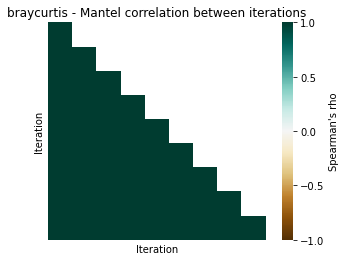

In [14]:
choices = ('matching', 'aitchison', 'euclidean', 'generalized_unifrac', 'canberra', 'russellrao', 'braycurtis', 'cosine', 'jensenshannon', 'yule', 'weighted_normalized_unifrac', 'unweighted_unifrac', 'hamming', 'weighted_unifrac', 'cityblock', 'sokalmichener', 'seuclidean', 'rogerstanimoto', 'correlation', 'minkowski', 'kulsinski', 'chebyshev', 'sqeuclidean', 'sokalsneath', 'jaccard', 'dice', 'canberra_adkins')
clustering_methods = ('nj', 'upgma')
correlation_methods = ('pearson', 'spearman')

sampling_depth = max(min_feature_count, 1)
metric = 'braycurtis'
clustering_method = clustering_methods[0]
correlation_method = correlation_methods[1]

beta_rar = beta_rarefaction(
    table = tabs,
    sampling_depth  = sampling_depth,
    metadata = metadata_qa,
    metric = metric,
    clustering_method = clustering_method,
    correlation_method = correlation_method,
)

 ## Beta diversity PCoA
 Ellipses represent 95% confidence intervals.

In [15]:
plot_tmp = f'{metric}-{clustering_method}-{correlation_method}-{sampling_depth}'
beta_rarefaction_view_path = os.path.join(qiime_folder, f'beta-rarefaction-{plot_tmp}.qzv')
beta_rar.visualization.save(beta_rarefaction_view_path)

beta_rar.visualization

<visualization: Visualization uuid: d89dcbef-98c7-4895-8f87-9ac5ee9c9a08>